In [64]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import seaborn as sns
import random

# Generalized Bayes Update

This is the bayes rule generalized to include self-serving beliefs. 
A self-serving belief will update asymmetrically when the evidence is positive or negative. When the evidence is positive, it will overweight the likelihood that it was generated by a pair of parameters such that $\theta > \omega$ and underweight the likelihood that it was generated by a pair of parameters such that $\theta < \omega$. When the evidence is negative, it will overweight the likelihood that it was generated by a pair of parameters such that $\theta < \omega$ and underweight the likelihood that it was generated by a pair of parameters such that $\theta > \omega$. This is done by adding parameters $c(\theta, \omega, news)$ such that

$$c(\theta_H, \omega, \text{good news}) < c(\theta_M, \omega, \text{good news}) < c(\theta_H, \omega, \text{bad news}) \quad \forall \omega$$
    And
    $$c(\theta, \omega_L, \text{good news}) < c(\theta, \omega_M, \text{good news}) < c(\theta, \omega_H, \text{bad news}) \quad \forall \theta$$

I will consider news to be good whenever more than half of the evidence is positive and bad whenever more than half of the evidence is negative.

The generalized bayes update rule is then given by:

$$ p_t(\theta, \omega) = \frac{p(s_t|\theta, \omega)^{c(\theta, \omega, news)}p_{t-1}(\theta, \omega)}{\sum_{\theta'}\sum_{\omega'}p(s_t|\theta', \omega')^{c(\theta', \omega', news)}p_{t-1}(\theta', \omega')} $$

where $news$ is good if $s/trials$ is greater than 0.5 and bad otherwise.

If $c$ is set to be constant ans equal to 1 for all possible values, then we get the standard bayes rule.



# The Data Generating Process

There are 3 values of $\theta$ and 3 values of $\omega$. The probability of success is increasing in $\theta$ and $\omega$ and is maximized by choosing $e=\omega$.

The following table summarizes the DGP:

|               | $\omega_L$ | $\omega_M$ | $\omega_H$ |               | $\omega_L$ | $\omega_M$ | $\omega_H$ |               | $\omega_L$ | $\omega_M$ | $\omega_H$ |
|:-------------:|:----------:|:----------:|:----------:|:-------------:|:----------:|:----------:|:----------:|:-------------:|:----------:|:----------:|:----------:|
|     $e_H$     |     20     |     25     |     40      |     $e_H$     |     40     |     45     |    65      |     $e_H$     |     45     |     55     |     75     |
|     $e_M$     |     7      |     30     |     45      |     $e_M$     |     30     |     65     |     69     |     $e_M$     |     35     |     69     |     80     |
|     $e_L$     |     2      |     20     |     50      |     $e_L$     |      5     |     50     |     80     |     $e_L$     |     25     |     65     |     98     |
|               |            | $\theta_L$ |            |               |            | $\theta_M$ |            |               |            | $\theta_H$ |            |


In [65]:
# set the parameters
seeds = [3452, 3452, 3452]

# number of periods
T = 11

# number of trials
be_trials = 10


In [66]:
# the dgp
# matrices: matrix[0] is the low type, matrix[2] is the high type. column 0 is low omega, row 0 is low effort
ml = np.array([[.20, .25, .40], [.07, .30, .45], [.02, .20, .50]])
mm = np.array([[.40, .45, .65], [.30, .65, .69], [.05, .50, .80]])
mh = np.array([[.45, .55, .75], [.35, .69, .80], [.25, .65, .98]])

msc = [ml, mm, mh]


In [67]:
###### THIS IS THE BAYES UPDATE WITH THE BIAS PARAMETERS C######
# joint bayesian update

def joint_bayes_biased(p0, signal, M, e_index, c):
    # number of sucesses
    k = sum(signal)
    n = len(signal)
    # determine if it is good news or bad news and set the parameter c accordingly
    
    if k>=n/2:
        c_H = c[0]
        c_M = c[1]
        c_L = c[2]
    else:
        c_L = c[3]
        c_M = c[4]
        c_H = c[5]
    
    # the probabilities of having observed each of the signals
    matrix = np.array([sp.stats.binom.pmf(k, n, M[0][e_index, :], loc=0), 
                       sp.stats.binom.pmf(k, n, M[1][e_index, :], loc=0), 
                       sp.stats.binom.pmf(k, n, M[2][e_index, :], loc=0)])
    
    
    if k>=n/2:
        matrix_bias = [[matrix[0, 0]**c_L, matrix[0, 1]**c_L, matrix[0, 2]**c_L],
                       [matrix[1, 0]**c_M, matrix[1, 1]**c_M, matrix[1, 2]**c_M],
                       [matrix[2, 0]**c_H, matrix[2, 1]**c_H, matrix[2, 2]**c_H]]
    else:
        matrix_bias = [[matrix[0, 0]**c_L, matrix[0, 1]**c_M, matrix[0, 2]**c_H],
                       [matrix[1, 0]**c_L, matrix[1, 1]**c_M, matrix[1, 2]**c_H],
                       [matrix[2, 0]**c_L, matrix[2, 1]**c_M, matrix[2, 2]**c_H]]
    
    # set the numerators
    num = np.diagflat(p0) @ np.diagflat(matrix_bias)
    #take only the diagonal
    num = np.diag(num)

    # sum all the numerators to get the denominator
    denom = np.sum(num)

    # the posterior beliefs are each of the numerators divided by the denominator
    p1 = num/denom

    # p1 has the order (00, 01, 02, 10, 11, 12, 20, 21, 22)
    
    return p1

In [68]:
# bayesian choices (the inputs are the belief (nine-dimensional array) and the DGP (msc), returns the index of the choice that maximizes the expected utility)
# this can be used for the unbiased and the biased updates since it only takes the posterior belief ans calculates the expectated utility for each of the choices

def joint_bayes_c(p1, M):
    # compute the expected payoffs for each of the 3 choices
    # the expected payoff is the probability of success times the probability of that combination of parameters
    # Take the first row of each of the matrices in M and cancatenate them (this will match the order of the probabilities in the posterior)
    choices_1 = np.concatenate((M[0][0, :], M[1][0, :], M[2][0, :]))
    # Take the second row of each of the matrices in M and stack them
    choices_2 = np.concatenate((M[0][1, :], M[1][1, :], M[2][1, :]))
    # Take the third row of each of the matrices in M and concatenate them
    choices_3 = np.concatenate((M[0][2, :], M[1][2, :], M[2][2, :]))

    # multiply the choices by the probabilities in the posterior
    Eu= [choices_1@p1, choices_2@p1, choices_3@p1]

    e_index = np.argmax(Eu)
    
    return e_index
    


In [69]:
# function that simulates the joint biased bayes only (this can be turned into the correct bayesian y settinc c=[1, 1, 1, 1])

def simulate_joint_bayes_biased(theta, omega, p0_theta, p0_omega, M, c, T, trials, seeds):
    
    ###### Determine the outcomes beforehand
    # set a seed for each type
    rng_H = np.random.default_rng(seed=seeds[0])
    
    

    #############
    # generate all the draws for T periods for each type and for each effort choice
    ############

    ##### for the high types
    # outcomes after choosing L
    outcome_H_L = rng_H.binomial(1, M[2][0, omega], size=(T, trials))
    # outcomes after choosing M
    outcome_H_M = rng_H.binomial(1, M[2][1, omega], size=(T, trials))
    # outcomes after choosing H
    outcome_H_H = rng_H.binomial(1, M[2][2, omega], size=(T, trials))

    ##### for the medium types
    rng_M = np.random.default_rng(seed=seeds[1])
    # after low effort
    outcome_M_L = rng_M.binomial(1, M[1][0, omega], size=(T, trials))
    # after medium effort
    outcome_M_M = rng_M.binomial(1, M[1][1, omega], size=(T, trials))
    # after high effort
    outcome_M_H = rng_M.binomial(1, M[1][2, omega], size=(T, trials))

    #### for the low types
    rng_L = np.random.default_rng(seed=seeds[2])
    outcomes_L_L = rng_L.binomial(1, M[0][0, omega], size=(T, trials))
    outcomes_L_M = rng_L.binomial(1, M[0][1, omega], size=(T, trials))
    outcomes_L_H = rng_L.binomial(1, M[0][2, omega], size=(T, trials))

    # stack the outcome vectors foe each type into a matrix. first element is the effort choice, secod is t
    outcomes_H = np.stack((outcome_H_L, outcome_H_M, outcome_H_H))
    outcomes_M = np.stack((outcome_M_L, outcome_M_M, outcome_M_H))
    outcomes_L = np.stack((outcomes_L_L, outcomes_L_M, outcomes_L_H))

    # stack all the matrices into a single outcomes matrix of matrices
    outcomes = np.stack((outcomes_L, outcomes_M, outcomes_H))
    
    
    #############
    # set empty vectors where all the data will be saved period by period for each of the models
    ############
    # beliefs
    # take every value of p0_theta and multiply by each value of p0_omega
    p_joint_bayes_biased = [np.kron(p0_theta, p0_omega)]
    
    # choices
    e_joint_bay_biased = [joint_bayes_c(p_joint_bayes_biased[0], M)]
    
    signals = outcomes[theta]
    
    for t in range(T):
        # get the signals 
        
        signal_bay = signals[e_joint_bay_biased[t], omega]
        
        # update beliefs 
        
        p1_joint = joint_bayes_biased(p_joint_bayes_biased[t], signal_bay, M, e_joint_bay_biased[t], c)
        p_joint_bayes_biased.append(p1_joint)
    
        
        # Choices for each model and each believed type
        e_joint_biased_t = joint_bayes_c(p_joint_bayes_biased[t], M)
        e_joint_bay_biased.append(e_joint_biased_t)
        
    return e_joint_bay_biased


I will simulate choices that the model for each possible prior and for a grid of possible parameter pairs. I will then find the pair of parameters that minimizes the distance between the simulated choices and the actual choices under each prior.

Once I have the parameters for each prior, I will average the parameters across all priors and use the average parameters to simulate choices again for each prior. I will then compare the simulated choices to the actual choices to determine the fit of the self-serving attribution model.

In [70]:
# all the priors on theta that an agent can have in the following order:
# uniform, 
# 50% chance belief on 0, 75% chance belief on 0, 100% chance belief on 0,
# 50% chance belief on 1, 75% chance belief on 1, 100% chance belief on 1,
# 50% chance belief on 2, 75% chance belief on 2, 100% chance belief on 2.


priors_theta = [[1/3, 1/3, 1/3], 
                [1/2, 1/4, 1/4],
                [3/4, 1/8, 1/8],
                [9/10, 1/20, 1/20],
                [1/4, 1/2, 1/4],
                [1/8, 3/4, 1/8],
                [1/20, 9/10, 1/20],
                [1/4, 1/4, 1/2],
                [1/8, 1/8, 3/4],
                [1/20, 1/20, 9/10]]


# the prior on omega is induced and uniform
prior_omega = [1/3, 1/3, 1/3]



In [71]:
# for each of the priors, simulate the choices under each of the parameterizations of the bias from attributions
# where the attribution is [c_positive, c_negative, c_negative, c_positive] for each of the possible 
# combinations of c_positive and c_negative

# create a matrix of the possible combinations of c_positive and c_negative
c_H = np.array([x for x in range(10, 150, 5)])/100
c_M = np.array([x for x in range(10, 150, 5)])/100
c_L = 1

grid_good_HML = np.array(np.meshgrid(c_H, c_M, c_L)).T.reshape(-1, 3)
# turn into a data frame
grid_good_HML = pd.DataFrame(grid_good_HML, columns=['c_H', 'c_M', 'c_L'])

# keep only the combinations where c_H < c_M < c_L
grid_good_HML = grid_good_HML[grid_good_HML['c_H'] < grid_good_HML['c_M']]
grid_good_HML = grid_good_HML[grid_good_HML['c_M'] < grid_good_HML['c_L']]

# turn back into a numpy array
grid_good_HML = grid_good_HML.to_numpy()

In [72]:
grid_good_HML

array([[0.1 , 0.15, 1.  ],
       [0.1 , 0.2 , 1.  ],
       [0.1 , 0.25, 1.  ],
       [0.1 , 0.3 , 1.  ],
       [0.1 , 0.35, 1.  ],
       [0.1 , 0.4 , 1.  ],
       [0.1 , 0.45, 1.  ],
       [0.1 , 0.5 , 1.  ],
       [0.1 , 0.55, 1.  ],
       [0.1 , 0.6 , 1.  ],
       [0.1 , 0.65, 1.  ],
       [0.1 , 0.7 , 1.  ],
       [0.1 , 0.75, 1.  ],
       [0.1 , 0.8 , 1.  ],
       [0.1 , 0.85, 1.  ],
       [0.1 , 0.9 , 1.  ],
       [0.1 , 0.95, 1.  ],
       [0.15, 0.2 , 1.  ],
       [0.15, 0.25, 1.  ],
       [0.15, 0.3 , 1.  ],
       [0.15, 0.35, 1.  ],
       [0.15, 0.4 , 1.  ],
       [0.15, 0.45, 1.  ],
       [0.15, 0.5 , 1.  ],
       [0.15, 0.55, 1.  ],
       [0.15, 0.6 , 1.  ],
       [0.15, 0.65, 1.  ],
       [0.15, 0.7 , 1.  ],
       [0.15, 0.75, 1.  ],
       [0.15, 0.8 , 1.  ],
       [0.15, 0.85, 1.  ],
       [0.15, 0.9 , 1.  ],
       [0.15, 0.95, 1.  ],
       [0.2 , 0.25, 1.  ],
       [0.2 , 0.3 , 1.  ],
       [0.2 , 0.35, 1.  ],
       [0.2 , 0.4 , 1.  ],
 

In [73]:
# define a function that will generate the simulated data for a particular prior_theta from the 10 priors that we have
# and for a particular combination of theta and omega
def ss_simulation(theta, omega, p0_theta, p0_omega, msc, grid, T, be_trials, seeds):
    # create an empty data frame with the columns that will be filled in
    rounds = [t+1 for t in range(T+1)]
    sim = pd.DataFrame(columns=['round', 'effort', 'theta', 'omega', 'c_good_H', 'c_good_M', 'c_good_L'])
    for i in range(len(grid_good_HML)):
        sim_c = pd.DataFrame(columns=['round', 'effort', 'theta', 'omega', 'c_good_H', 'c_good_M', 'c_good_L'])
        c = [grid_good_HML[i, 0], grid_good_HML[i, 1], grid_good_HML[i, 2], grid_good_HML[i, 2], grid_good_HML[i, 1], grid_good_HML[i, 0]]
        e = simulate_joint_bayes_biased(theta, omega, p0_theta, p0_omega, msc, c, T, be_trials, seeds)
        sim_c['round'] = rounds
        sim_c['c_H'] = c[0]
        sim_c['c_M'] = c[1]
        sim_c['c_L'] = c[2]
        sim_c['theta'] = theta
        sim_c['omega'] = omega
        sim_c['effort'] = e
        
        sim = pd.concat([sim, sim_c])
    
    sim['prior'] = int(np.round(max(p0_theta), 2)*100)
        
    return sim





In [74]:
# simulate for all the values of (theta, omega) and for all the priors
simulation_all = pd.DataFrame(columns=['round', 'effort', 'theta', 'omega', 'prior'])
for x in [0, 1, 2]:
    for y in [0, 1, 2]:
        for k in priors_theta:
            simulation_all = pd.concat([simulation_all, 
            ss_simulation(x, y, k, prior_omega, msc, grid_good_HML, 10, be_trials, seeds).reset_index()])

simulation_all




,round,effort,theta,omega,prior,index,c_good_H,c_good_M,c_good_L,c_H,c_M,c_L
0,1,1,0,0,33,0.0,NaN,NaN,NaN,0.1,0.15,1.0
1,2,1,0,0,33,1.0,NaN,NaN,NaN,0.1,0.15,1.0
2,3,1,0,0,33,2.0,NaN,NaN,NaN,0.1,0.15,1.0
3,4,1,0,0,33,3.0,NaN,NaN,NaN,0.1,0.15,1.0
4,5,1,0,0,33,4.0,NaN,NaN,NaN,0.1,0.15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1678,7,2,2,2,90,6.0,NaN,NaN,NaN,0.9,0.95,1.0
1679,8,2,2,2,90,7.0,NaN,NaN,NaN,0.9,0.95,1.0
1680,9,2,2,2,90,8.0,NaN,NaN,NaN,0.9,0.95,1.0
1681,10,2,2,2,90,9.0,NaN,NaN,NaN,0.9,0.95,1.0


In [75]:
simulation_all.reset_index(inplace=True)
simulation_all.to_csv('demo/data/simulation_ss.csv')

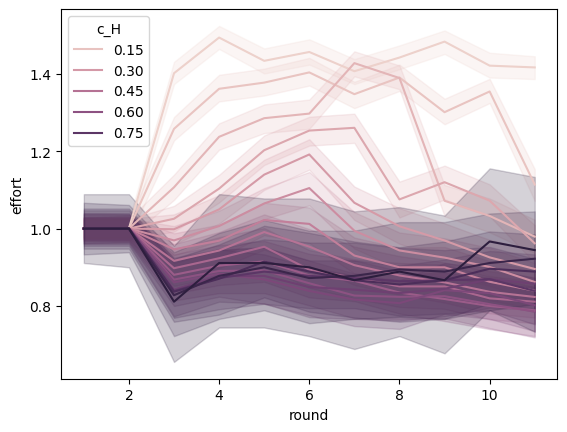

In [76]:
sns.lineplot(data=simulation_all, x='round', y='effort', hue='c_H')
# save the plot
plt.savefig('../figures/self-serving_11.png')